In [1]:
!pip install --upgrade pip    #cclab request was fulfilled

Requirement already up-to-date: pip in ./common/.virtualenv/python3/lib/python3.5/site-packages


At the begining on the code we will import all the librarires we will need for the assignment

In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer #allows to take care of missing data
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import pointbiserialr
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


now we will import the files: testing.csv and raw.csv via drag and drop on this window and we will use them in our code below

In [82]:
#load data from the CSV FILE
dataset = pd.read_csv('raw.csv')
#show data 
dataset.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K


Section 1: Data Cleaning

we must find all the columns where data is missing

In [83]:
print(dataset.columns[dataset.isnull().any()] )

Index(['WorkClass', 'Occupation', 'NativeCountry'], dtype='object')


Hence we find that in our data WorkClass, Occupation and Native country is missing the data. Before we make changes, we should have insights about the data. That can be done by visualizing the data

PLEASE NOTE: all the bar graphs's y-axis denotes the count number of that bar in teh graph

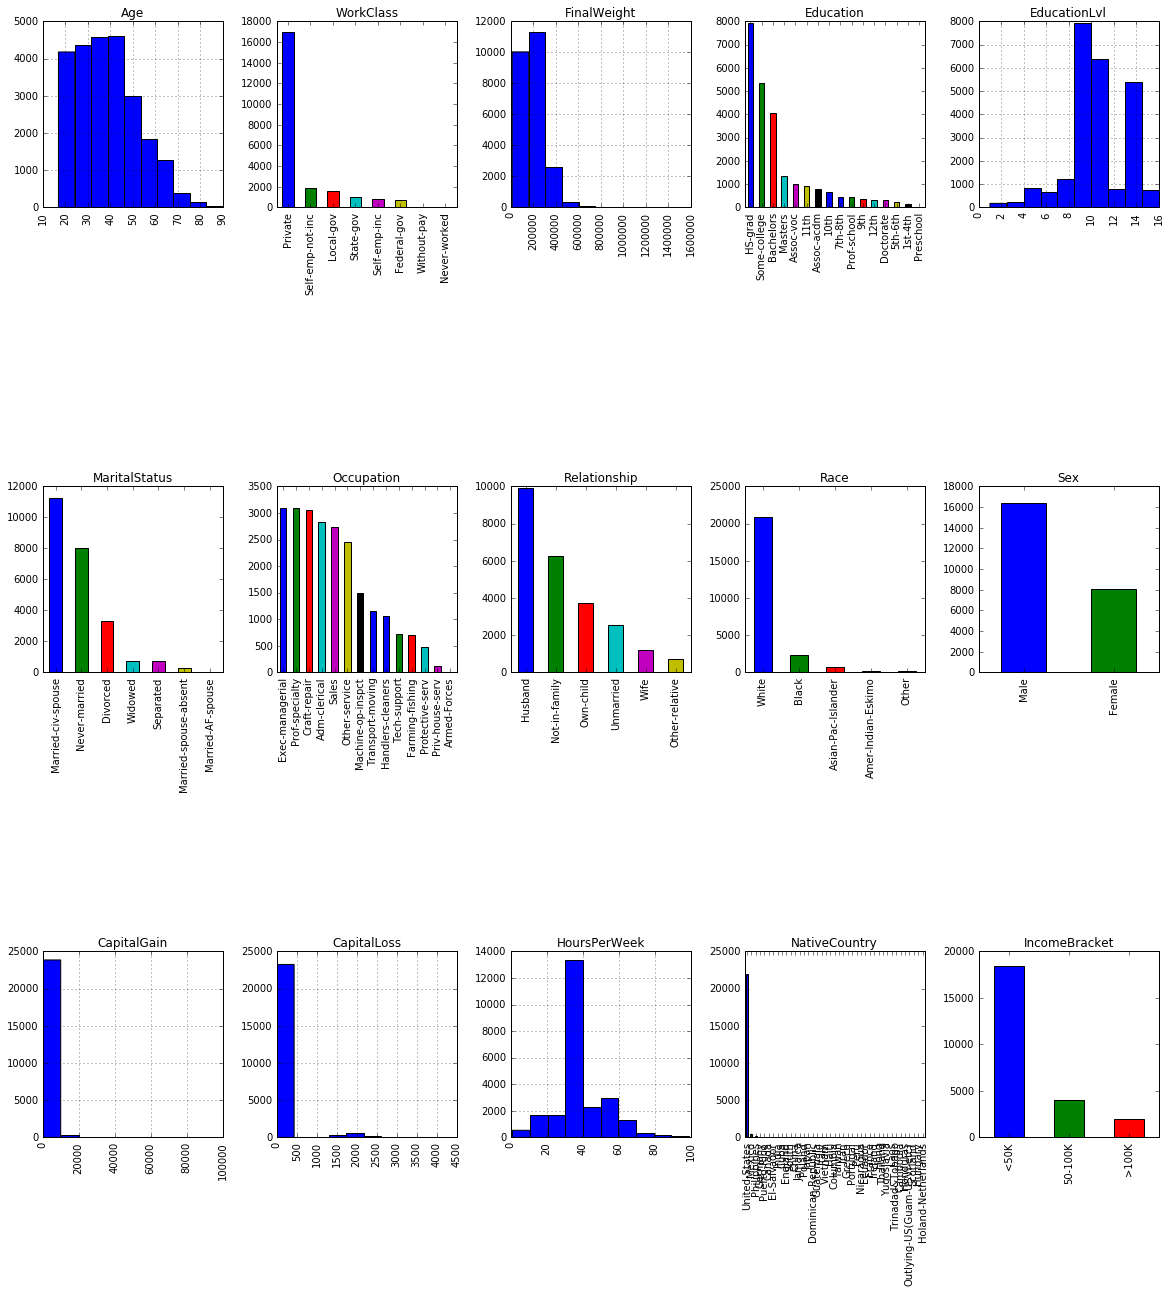

In [84]:
#visualize the raw data
import math
#displays the graphs inline with data
%matplotlib inline 
figure = plt.figure(figsize = (20,20))
cols = 5
rows = math.ceil(float(dataset.shape[1])/cols)

for i, column in enumerate(dataset.columns):
    ax = figure.add_subplot(rows,cols,i+1)
    ax.set_title(column)
    if dataset.dtypes[column] == np.object:
        dataset[column].value_counts().plot(kind ="bar", axes =ax)
    else:
        dataset[column].hist(axes=ax)
        plt.xticks(rotation ="vertical")
plt.subplots_adjust(hspace =1.5, wspace = 0.3) #leaves space so that xaxis labels are readable

From the graphs we notice that data is very heavily skewed towards one category when it comes to Race and NativeCountry. Numerically it can be shows as follows:

In [85]:
(dataset["Race"].value_counts()/dataset.shape[0]).head()


White                 0.856230
Black                 0.095696
Asian-Pac-Islander    0.030916
Amer-Indian-Eskimo    0.009377
Other                 0.007780
Name: Race, dtype: float64

In [86]:
(dataset["NativeCountry"].value_counts()/dataset.shape[0]).head()

United-States    0.899963
Mexico           0.019860
Philippines      0.005978
Germany          0.003931
Puerto-Rico      0.003685
Name: NativeCountry, dtype: float64

We notice that the data in for Race is skewed for white by 85.62% and NativeCountry is skewed for United-States by 89.99% . Hence we can proceed to remove Race and NativeCountry from the table


In [87]:
del dataset["Race"]
del dataset["NativeCountry"]

Even after the analysis (looking at histogram) above and deleting the two columns, we still have missing data in the rows of 'WorkClass' and 'Occupation'. If they are very small portions in their columns, we may delete those row. In order to do that we will run the following code to see portion of missing data


In [88]:
WorkClass_missing =(len(dataset["WorkClass"])-(dataset["WorkClass"].count()))/(dataset["WorkClass"].count())
print(WorkClass_missing)

0.0600772670053


In [89]:
Occupation_missing =(len(dataset["Occupation"])-(dataset["Occupation"].count()))/(dataset["Occupation"].count())
print(Occupation_missing)

0.0603534366723


if we delete rows due to both missing data in both columns, we coul potentially lose a lot of data (around 12%). That will be very significant amount of data.

based on the graphs generated before we can substitute the values using in WorkClass with the the mode value

In [90]:
(dataset["WorkClass"].value_counts()/dataset.shape[0]).head()


Private             0.696204
Self-emp-not-inc    0.078211
Local-gov           0.064453
State-gov           0.040048
Self-emp-inc        0.034560
Name: WorkClass, dtype: float64

#Now for "WorkClass" missing values will get the value "Private", where as for "Occupation" as we will delete the rows with missing values


In [91]:
dataset["WorkClass"] = dataset["WorkClass"].replace(np.nan,'Private')  #replace the nan in Workclass with 'Private'


now only Occupation has Nan values in dataset and we will drop all the rows with missing values


In [92]:
dataset = dataset.dropna()

Before we proceed to exploratory analysis, it is really important that we convert our categorical data into  numerical values using encoding. We will keep two copies of data, encoded and non-encoded

Data Encoding

In [93]:
edataset = dataset.copy()
labelencoder_col = LabelEncoder()
#dataencoding commands below for columns
edataset.iloc[:,1] = labelencoder_col.fit_transform(edataset.iloc[:,1])
edataset.iloc[:,3] = labelencoder_col.fit_transform(edataset.iloc[:,3])
edataset.iloc[:,5] = labelencoder_col.fit_transform(edataset.iloc[:,5])
edataset.iloc[:,6] = labelencoder_col.fit_transform(edataset.iloc[:,6])
edataset.iloc[:,7] = labelencoder_col.fit_transform(edataset.iloc[:,7])
edataset.iloc[:,8] = labelencoder_col.fit_transform(edataset.iloc[:,8])
edataset.iloc[:,12] = labelencoder_col.fit_transform(edataset.iloc[:,12])
edataset.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Sex,CapitalGain,CapitalLoss,HoursPerWeek,IncomeBracket
0,42,5,179151,15,10,2,4,0,1,0,0,40,1
1,28,2,68021,15,10,4,7,1,0,0,0,30,1
2,24,2,233499,15,10,2,13,0,1,0,0,40,0
3,32,4,168782,6,5,2,2,0,1,0,0,32,1
4,55,4,105582,12,14,2,11,0,1,2228,0,50,1


Now we finished the data analysis, we can now proceed to Exploratory analysis


Section 2: Exploratory Analysis

Create heat map to get insights about feature interactions

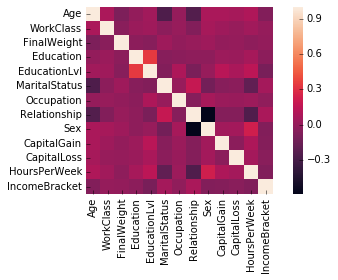

In [94]:
sns.heatmap(edataset.corr(), square=True) #generated the heatmap of correlation
#formatting commands to make the graph readable
plt.xticks(rotation=90)
plt.tight_layout()
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

GRAPH 1
We notice that the information is scattered on the across the heat map, hence we should cluster the information togther based on their correlation with the help of this graph, we will know the order which features are correlated

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


ValueError: max() arg is an empty sequence

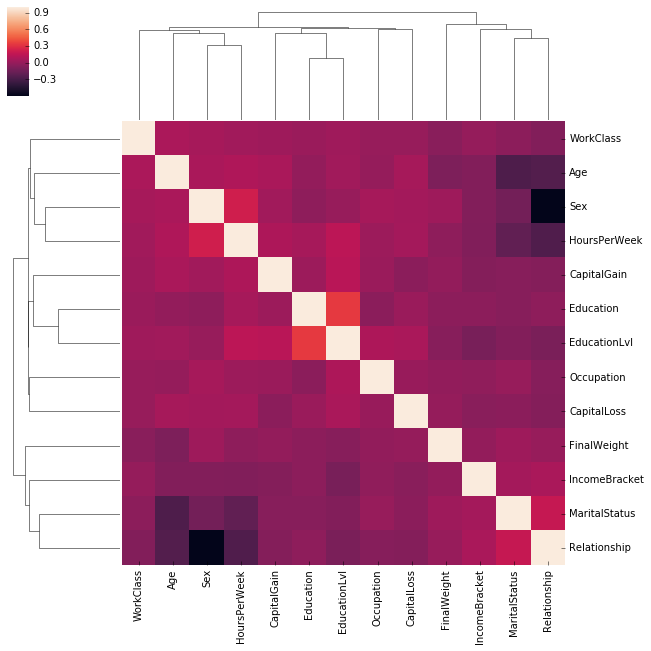

In [95]:
cg = sns.clustermap(edataset.corr()) #clustering will group the features accordingly
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
plt.show()

Here we notice that there is a strong positive correlation between the Education & Educationlvl and very strong negative correlation between the sex and relationship. Hence we will look more into these relations to get some insights. Based on those insights we can take further decision and get better insights
Let us display Education and EducationLvl to get some insights

In [96]:
dataset[["Education","EducationLvl"]].head(20) 

,Education,EducationLvl
0,Some-college,10
1,Some-college,10
2,Some-college,10
3,9th,5
4,Masters,14
5,HS-grad,9
6,Bachelors,13
7,HS-grad,9
8,Assoc-voc,11
10,HS-grad,9


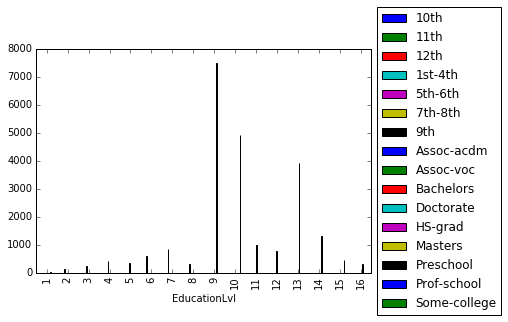

In [97]:

pd.crosstab(dataset['EducationLvl'], dataset['Education']).plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
education_relation= dataset[["Education","EducationLvl"]].copy()

By looking at the datatable and plot above we realize that education and education level are directly related, hence we can deleted education column. Reason being, it is rudundant information


In [98]:
del dataset["Education"]
del edataset["Education"] #deleting data from both the tables

Graph 2
As discussed before, there is negative corelation between Relationship and sex. Hence now let us now display the pair plot to get some insights


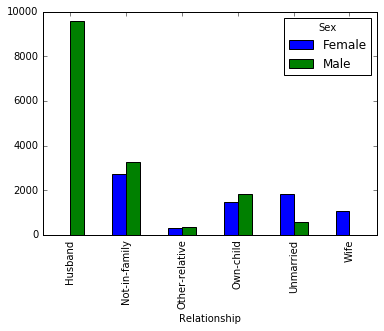

In [99]:
dataset[["Relationship","Sex"]].head(20) 
pd.crosstab(dataset['Relationship'], dataset['Sex']).plot.bar()
relation_sex = dataset[["Relationship","Sex"]].copy()

Here we do not see any redundant relationship between Relationship and Sex similar to Education and EducationLvL. But as a part of exploratory analysis, we notice that the data is heavily domiated by males. In terms of relationship most of them are husband.


Graph 3
last graph will show the how income is distributed across age of people

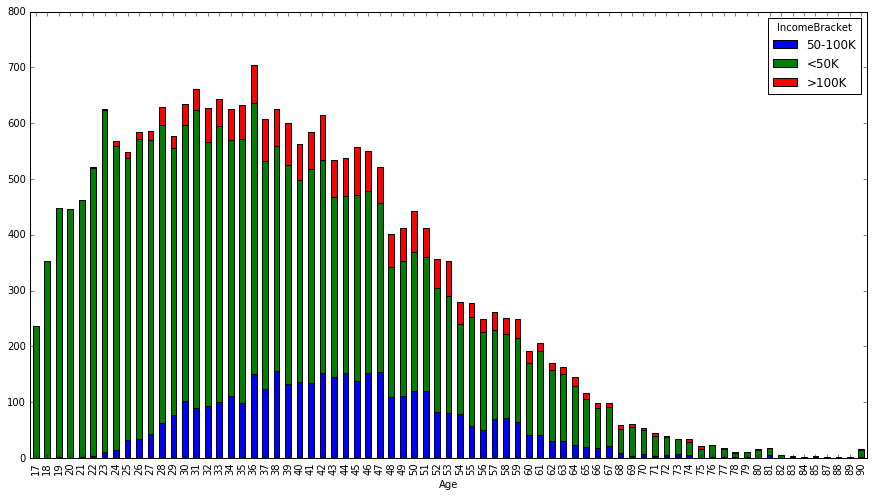

In [100]:
graph = pd.crosstab((dataset['Age']),dataset['IncomeBracket'])
graph.plot.bar(stacked = True, figsize =(15,8))

From the stacked graph above we notice that there data is more skewed towards ages less than 55 years. But more importantly we notice that for high majority of ages, therewere more people with the lowest income (<50K) 

Section 3: Feature Engineering

Feature engineering helpes select or develop new features that can be useful in our predictive model. it also helps in increasing the computation speed of model because it can guide that quantatively how some features might not be affecting the final answer so much.

From the original histogram graphs we notice that in terms of hrs, majority of people work 40hrs a week. We also notice that interms of age, the data is more skewed towrds ages below 55

Hence we can create 4 features.
First that categorizes the hrs/week data into bins equally.
Second that categorizes the age data into bins equally.
Third product of hrs/week and age to amplify the combination of two factors
Fourth will be categorize the age and hrs product into bins equally

In [101]:
#first feature
dataset['Age_bin'] = pd.cut(dataset['Age'],15)

#second feature
dataset['Hrs_bin'] = pd.cut(dataset['HoursPerWeek'],15)

#third feature is the product of person's age and hours they work everyweek
dataset['Age_Hrs'] = dataset['Age'] * dataset['HoursPerWeek']

#fourth feature
dataset['Age_Hrs_bin'] = pd.cut(dataset['Age_Hrs'],15)

Setting up this data in encoded dataset

In [102]:
#copy the columns to edata set to encode few more columns
edataset[['Age_bin','Hrs_bin','Age_Hrs','Age_Hrs_bin']] = dataset[['Age_bin','Hrs_bin','Age_Hrs','Age_Hrs_bin']]

#ecoding the columns with bins
edataset.iloc[:,12] = labelencoder_col.fit_transform(edataset.iloc[:,12])
edataset.iloc[:,13] = labelencoder_col.fit_transform(edataset.iloc[:,13])
edataset.iloc[:,15] = labelencoder_col.fit_transform(edataset.iloc[:,15])



Now in order to select the features for our machine learning models in next section we will generate the table with Point-Biserial Corelation. Point-biserial correlation is used to measure the strength and direction of the association that exists between one continuous variable and one dichotomous variable.


In [103]:
dataset_columns =[]
pbs_correlation = []

for cols in edataset.columns:
    if cols!="IncomeBracket":
        relation = pointbiserialr(edataset['IncomeBracket'],edataset[cols])[0]
        dataset_columns.append(cols)
        pbs_correlation.append(relation)
        
feature_df = pd.DataFrame({'pbs_correlation':pbs_correlation, 'Column_name': dataset_columns})

#dataframe indexed on parameter name
feature_df = feature_df.set_index('Column_name')

#sort the values based on magnitude of correlation values
feature_df = feature_df.sort_values(by = ['pbs_correlation'], ascending = False)
    
#display the chart
feature_df


,pbs_correlation
Column_name,
Relationship,0.078083
MaritalStatus,0.059833
WorkClass,0.001706
FinalWeight,-0.002721
Occupation,-0.014322
CapitalLoss,-0.040231
CapitalGain,-0.058313
Age_bin,-0.061056
Age,-0.062692


Of the 15 total features in the edataset, we will select the following with features with correlation greater than magnitude of 0.06

# First feature:  EducationLvl       
# Second feature: Age_Hrs
# Third feature:  Relationship
# Fourth feature: HoursPerWeek
# Fifth feature:  Sex
# Sixth feature:  Age

#we did not select the age bin, hrs bin and age_hrs bin because the information is already covered under the features selected


Section 4: Model Implementation

Before we do the model implementation, we must create two tables. One with only features and other with the values that we are trying to classify

In [104]:
X = edataset[['EducationLvl','Age_Hrs','Relationship','HoursPerWeek','Sex','Age']].copy()
Y = edataset['IncomeBracket']

#now we can proceed with the model implementation

# Random forest

what it does: it works by creating matiple decision trees (based on random feature selected) at training time and outputting the class that is the mode of classification of the every tree

pros:Decorrelates trees (important when dealing features with high correlation)

cons: interpretation(visually) is difficult

reason to choose: creates multiple trees and find the opitmal solutions based on all the trees

In [24]:
randomforest = RandomForestClassifier()
rf_score = cross_val_score(randomforest,X,Y, cv = 10,scoring = "accuracy")
rf_score_mean = rf_score.mean()
rf_score_std = rf_score.std()
print(rf_score_mean)
print(rf_score_std)

0.74851291291
0.0040131131111


Insights about the score:

In [25]:
randomforest = RandomForestClassifier()
randomforest.fit(X,Y)
y_predict = randomforest.predict(X)
print(classification_report(Y,y_predict))
confusion_matrix(Y, y_predict)

             precision    recall  f1-score   support

          0       0.71      0.63      0.67      3904
          1       0.90      0.96      0.93     17180
          2       0.72      0.47      0.57      1947

avg / total       0.85      0.86      0.85     23031



array([[ 2471,  1222,   211],
       [  581, 16459,   140],
       [  423,   616,   908]])

Bias vairance discussion for random forest: by looking at the cross fold mean, classification report and confusion matrix we found that the model is able to classify the data for all the 3 categories. by looking at the precision and recall score the model have relatively higher variance as the precision and recall scores were high for some categories.

# Gaussian Naive Bayes

what it does: use the bayes theorem with an assumption of independence among predictors

pros: computationally fast and works well with high dimensions. very useful for large dataset

cons: relies on the assumption that every test of information has an independene

reason to choose: simple to implement and categorizes based on the uniqueness. If the data sets has any uniquness, this algorith will be very helpful


In [26]:
gnb = GaussianNB()
gnb_score = cross_val_score(gnb,X,Y, cv = 10,scoring = "accuracy")
gnb_score_mean = gnb_score.mean()
gnb_score_std = gnb_score.std()
print(gnb_score_mean)
print(gnb_score_std)

0.747514837467
0.00572618426422


Insights about the score:

In [27]:
gnb = GaussianNB()
gnb.fit(X,Y)
y_predict = gnb.predict(X)
print(classification_report(Y,y_predict))
confusion_matrix(Y, y_predict)

             precision    recall  f1-score   support

          0       0.40      0.57      0.47      3904
          1       0.86      0.87      0.86     17180
          2       0.14      0.00      0.00      1947

avg / total       0.72      0.75      0.73     23031



array([[ 2243,  1661,     0],
       [ 2195, 14979,     6],
       [ 1128,   818,     1]])

Bias vairance discussion for Gaussian NB: by looking at the cross fold mean, classification report and confusion matrix we found that though the mean is greater than 70 the model has high bias. It was clearly visible inb the classification report and confusion matrix as the model was poorly predicting a categorial output


# Logistic regression

what it does: here multiclass logistic regression is used. over multiple iteration one output is tested against all other outputs. In order to do that normal logistic binary classification is used

pros: provides probabilities of teh outcomes

cons: high bias

reason to chose: very helpful explaining which features are affecting the output more

In [28]:
lor = LogisticRegression()
lor_score = cross_val_score(lor,X,Y, cv = 10,scoring = "accuracy")
lor_score_mean = lor_score.mean()
lor_score_std = lor_score.std()
print(lor_score_mean)
print(lor_score_std)

0.767704669886
0.00447268673436


Insights about the score:

In [29]:
lor = LogisticRegression()
lor.fit(X,Y)
y_predict = lor.predict(X)
print(classification_report(Y,y_predict))
confusion_matrix(Y, y_predict)

             precision    recall  f1-score   support

          0       0.50      0.28      0.36      3904
          1       0.80      0.97      0.87     17180
          2       0.00      0.00      0.00      1947

avg / total       0.68      0.77      0.71     23031



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[ 1083,  2821,     0],
       [  577, 16603,     0],
       [  525,  1422,     0]])

bias variance discussion from Logistic regression: by looking at the cross fold mean, classification report and confusion matrix we found that though the mean is greater than 70 the model has high bias. It was clearly visible inb the classification report and confusion matrix as the model was poorly predicting a categorial output


# Decision tree

what it does: it keeps dividing the data into smaller and smaller categories while at the same time and associated tree is developed

pros: Interpretable. can handle the irrelevant attribute and missing data

cons:  can create multiple solutions without feedback on which solution is better than other.

reason to chose: easy to implement and classified data is interpretable


In [30]:
decision_tree = DecisionTreeClassifier()
decision_tree = cross_val_score(decision_tree,X,Y, cv = 10,scoring = "accuracy")
decision_tree_mean = decision_tree.mean()
decision_tree_std = decision_tree.std()
print(decision_tree_mean)
print(decision_tree_std)

0.729755315619
0.00479595579424


Insights about the score:

In [31]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X,Y)
y_predict = decision_tree.predict(X)
print(classification_report(Y,y_predict))
confusion_matrix(Y, y_predict)

             precision    recall  f1-score   support

          0       0.68      0.72      0.70      3904
          1       0.91      0.95      0.93     17180
          2       0.84      0.41      0.55      1947

avg / total       0.87      0.87      0.86     23031



array([[ 2795,  1016,    93],
       [  763, 16362,    55],
       [  543,   606,   798]])

bias-variance discussion from decision tree:  by looking at the cross fold mean, classification report and confusion matrix we found that the deicison tree was able to predict data for all the three categories. but we noticed that results have bia as the recall score of category 2 is much lower than other categories 


Based on our analysis we found that there are Logistic regression has the highest score (mean) and Random forest has the second highest score.

Section 5: Model Tuning

In order to tune our models we will used the scoring parameter used in tuning will be the 'neg_log_loss'. Reason being this parameter (similar to logistic regression) punishes the system heavily when the prediction is wrong. As a result it will help tune the model at teh same time help reduce the error due to bias and variance


# Model tuning for random forest

In [32]:
model = RandomForestClassifier() 
parameters = {'n_estimators': [5,10,50,100,500], 'max_features': ['log2', 'sqrt','auto'], 
              'max_depth': [5, 10, 50,100,150], 'min_samples_split': [5,7,9,11], } 

grid_obj = GridSearchCV(model, parameters, scoring="neg_log_loss",n_jobs=5,cv = 10) 
grid_obj = grid_obj.fit(X,Y) 
model_params = grid_obj.best_params_

In [33]:
#Now we will sub the following parameters in the code below to test our model
print(model_params)

{'min_samples_split': 11, 'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 10}


In [34]:
new_rf = RandomForestClassifier(n_estimators = 500,max_depth=10,max_features='sqrt', min_samples_split =11)
new_rf_score = cross_val_score(new_rf, X,Y,cv=10, scoring = "accuracy")
new_rf_score_mean = new_rf_score.mean()
new_rf_score_std = new_rf_score.std()
print(new_rf_score_mean)
print(new_rf_score_std)

0.780860499893
0.00302560099668


now we will get insgihts on the data from this optimized model

In [38]:
new_rf = RandomForestClassifier()
new_rf.fit(X,Y)
y_predict = new_rf.predict(X)
print(classification_report(Y,y_predict))
confusion_matrix(Y, y_predict)

             precision    recall  f1-score   support

          0       0.71      0.64      0.67      3904
          1       0.90      0.96      0.93     17180
          2       0.71      0.47      0.56      1947

avg / total       0.85      0.86      0.85     23031



array([[ 2489,  1195,   220],
       [  598, 16431,   151],
       [  420,   615,   912]])

# Model Tunining for Logistic Regression

In [39]:
lor_model = LogisticRegression()
parameters = {'C' : [0.1,1,10,100,1000], 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag'],'max_iter':[10,100,1000]}
lor_grid_obj = GridSearchCV(lor_model, parameters, scoring="neg_log_loss",n_jobs=5,cv = 10)
lor_grid_obj = lor_grid_obj.fit(X,Y)
lor_model_params = lor_grid_obj.best_params_

/usr/local/lib/python3.5/dist-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

In [40]:
#Now we will sub the following parameters in the code below to test our model
print(lor_model_params)

{'C': 1000, 'max_iter': 1000, 'solver': 'newton-cg'}


In [41]:
#now we will use the above parameters to optimize the model and see performance
new_lor = LogisticRegression(C =1000, solver = 'newton-cg', max_iter = 1000)
new_lor_score = cross_val_score(new_lor,X,Y,cv=10, scoring = "accuracy")
new_lor_score_mean = new_lor_score.mean()
new_lor_score_std = new_lor_score.std()
print(new_lor_score_mean)
print(new_lor_score_std )

/usr/local/lib/python3.5/dist-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/local/lib/python3.5/dist-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/local/lib/python3.5/dist-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search fail

0.768095276023
0.00381994503041


now we will get insgihts on the data from this optimized model

In [42]:
new_lor.fit(X,Y)
y_predict = new_lor.predict(X)
print(classification_report(Y,y_predict))
confusion_matrix(Y, y_predict)

             precision    recall  f1-score   support

          0       0.50      0.29      0.37      3904
          1       0.80      0.96      0.87     17180
          2       0.00      0.00      0.00      1947

avg / total       0.68      0.77      0.71     23031



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[ 1129,  2775,     0],
       [  610, 16570,     0],
       [  541,  1406,     0]])

Here is we noticed that even though the overall performance of logistic regeression improved, the model is still biased as it is not able to predict one category and at the same time it is good at predicting the other two classes.

# Model tuning for Gaussian Naive Bayes

When it comes to Gaussian Naive Bayes, you can only tune it by changing the totaly number of features or data samples. otherwise there is only one solution to given number of features and datasamples.Since we want to make sure that we compare same data and same features (similar to other model), we cannot tune the Gaussian Naive Bayes. but we will do the classification report and confusion matrix.

In [43]:
gnb.fit(X,Y)
y_predict = gnb.predict(X)
print(classification_report(Y,y_predict))
confusion_matrix(Y, y_predict)


             precision    recall  f1-score   support

          0       0.40      0.57      0.47      3904
          1       0.86      0.87      0.86     17180
          2       0.14      0.00      0.00      1947

avg / total       0.72      0.75      0.73     23031



array([[ 2243,  1661,     0],
       [ 2195, 14979,     6],
       [ 1128,   818,     1]])

this GaussianNB model is also biased as it is very poor to detect one category of data but good at predicting the other categories.

# Model tuning for Decisiontreeclassifier

In [44]:
dt_model =DecisionTreeClassifier() 
parameters = {'max_features': ['log2', 'sqrt','auto'], 'max_depth': [5, 10, 50,100,150], 'min_samples_split': [3,5,7,9,11,13,15] } 

grid_obj = GridSearchCV(dt_model, parameters, scoring="neg_log_loss",n_jobs=5,cv = 10) 
grid_obj = grid_obj.fit(X,Y) 
dt_model_params = grid_obj.best_params_

In [45]:
#Now we will sub the following parameters in the code below to test our model
print(dt_model_params)

{'min_samples_split': 9, 'max_features': 'auto', 'max_depth': 5}


As mentioned above, Decision tree classifier will give us multipe results without feedback on which result is better. hence the reult generated here might not be the best solution.If grid search is run again, the parameters might change. While writing the code, we obtain max depth= 5, maxfeature = auto, minsamplessplit= 9

In [46]:
new_dt = DecisionTreeClassifier(max_depth=5,max_features='auto', min_samples_split =9)
new_dt_score = cross_val_score(new_dt, X,Y,cv=10, scoring = "accuracy")
new_dt_score_mean = new_dt_score.mean()
new_dt_score_std = new_dt_score.std()
print(new_dt_score_mean)
print(new_dt_score_std)

#insights of the results

new_dt.fit(X,Y)
y_predict = new_dt.predict(X)
print(classification_report(Y,y_predict))
confusion_matrix(Y, y_predict)

0.771787246175
0.0124973829838
             precision    recall  f1-score   support

          0       0.51      0.40      0.45      3904
          1       0.82      0.96      0.89     17180
          2       0.00      0.00      0.00      1947

avg / total       0.70      0.78      0.74     23031



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[ 1580,  2324,     0],
       [  724, 16456,     0],
       [  766,  1181,     0]])

upon optimization we found that Decision tree's performance over all got better but it was also biased. It was not able to detect one category of data at all. But we must also keep in mind that if we run optimization again, the result could differ as there is no feedback process in decesiontree to know which result is better than other. Hence it makes this algorith risky and not recommended for this use.

Hence based on the results (looking at mean over crossfolds, pricision and recall) of all the four algotrithms, we will use the Random Forest Algorithm. Reson being it is able to predict all the three states better than Logistic regression and GaussianNB (lower Bais). Also the data it generated is better quality data than decision tree because, its classification is based on the feedback from multiple trees compared to Decision tree(decision tree)


Part 6: Testing and Discussion

First we need to process the data same as the test data

In [48]:
#import the data
test_dataset = pd.read_csv('testing.csv')

#finding missing values
test_dataset.columns[test_dataset.isnull().any()]
#here we find that it has the same columns missing data as the train data

#we will delete the same column data as before
del test_dataset["Race"]
del test_dataset["NativeCountry"]

#fill the workclass column with Private, same as before
test_dataset["WorkClass"] = test_dataset["WorkClass"].replace(np.nan,'Private') 

#similar to before we will drop the rows with nan from Occupation
test_dataset = test_dataset.dropna()

#generating the agehour feature
test_dataset['Age_Hrs'] = test_dataset['Age'] * test_dataset['HoursPerWeek']

#copying the data for on which tuned model will work
X_test= test_dataset[['EducationLvl','Age_Hrs','Relationship','HoursPerWeek','Sex','Age']].copy()
Y_test = test_dataset['IncomeBracket']



In [50]:
#encoding the categorical data
X_test.iloc[:,2] = labelencoder_col.fit_transform(X_test.iloc[:,2])
X_test.iloc[:,4] = labelencoder_col.fit_transform(X_test.iloc[:,4])


In [52]:
Y_test.iloc[:] = labelencoder_col.fit_transform(Y_test.iloc[:])

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Now we will run the opitimized algorith on the test data

In [55]:
new_test_rf_score = cross_val_score(new_rf, X_test,Y_test, cv=10, scoring ="accuracy")
new_test_rf_score_mean = new_test_rf_score.mean()
new_test_rf_score_std = new_test_rf_score.std()
print(new_test_rf_score_mean)
print(new_test_rf_score_std)

0.732054540764
0.00863799641664


In [56]:
new_rf = RandomForestClassifier()
new_rf.fit(X_test,Y_test)
y_predict = new_rf.predict(X_test)
print(classification_report(Y_test,y_predict))
confusion_matrix(Y_test, y_predict)

             precision    recall  f1-score   support

          0       0.77      0.69      0.73      1939
          1       0.90      0.96      0.93      8515
          2       0.75      0.52      0.62      1067

avg / total       0.87      0.87      0.87     11521



array([[1336,  517,   86],
       [ 253, 8166,   96],
       [ 156,  353,  558]])

In terms of accuracy, the tuned model of RandomForest performed better than the non tuned model on the training data(78.08% accuracy for tuned model vs 74.8% accuracy for non-tuned model). 

Based on the data from classification report, we found that model is more biased towards one category(1). Hence making this more under fit scenario. It makes also makes sense it is baised because the training data has big majority of data related to that specific category. In order to fix this issues we must use the more features when training the model
